In [13]:
# This python notebook is used to build a "Continuous Bag of Words" language model 
# The CBOW model can be built on any language, given a corpus
# This script builds the CBOW model for Hindi and Telugu languages from the corpus provided by CivicDataLabs
# The output of this script is a language embeddings matrix for Hindi and Telugu trained on the provided corpus 
# Author - Karthik D

%matplotlib inline
import pandas as pd
import io
import pickle
import torch
from torch import nn
from torch.autograd import Variable
from torch.optim import SGD
import torch.nn.functional as F

CONTEXT_SIZE = 4
EMBEDDING_DIM = 300
EPOCH = 2
VERVOSE = 1

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load Data

In [2]:
df = pd.read_csv("~/CivicData/data_stories.csv")
df.synopsis = df.synopsis.str.replace(r'[0-9]', "")
df.synopsis = df.synopsis.str.replace(r'[$&+,:;=?@#|<>.^*()%!-\\{}‘‘’’]', "")

df.content = df.content.str.replace(r'[0-9]', "")
df.content = df.content.str.replace(r'[$&+,:;=?@#|<>.^*()%!-\\{}‘‘’’]', "")

eng_df = df[df.story_langugage=='English']
hin_df = df[df.story_langugage == 'Hindi']
tel_df = df[df.story_langugage == 'Telugu']


hin_df.content = hin_df.content.str.replace(r'[A-Za-z]', " ")
hin_df.synopsis = hin_df.synopsis.str.replace(r'[A-Za-z]', " ")

tel_df.content = tel_df.content.str.replace(r'[A-Za-z]', " ")
tel_df.synopsis = tel_df.synopsis.str.replace(r'[A-Za-z]', " ")

/opt/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


# Some Pre-processing

In [3]:
import re

tel_corpus = tel_df.synopsis.str.cat(sep=" ") + " " + tel_df.content.str.cat(sep=" ")
hin_corpus = hin_df.synopsis.str.cat(sep=" ") + " " + hin_df.content.str.cat(sep=" ")
eng_corpus = eng_df.synopsis.str.cat(sep=" ") + " " + eng_df.content.str.cat(sep=" ")

tel_corpus = tel_corpus.replace("\n","")
tel_corpus = tel_corpus.replace("\t","")
tel_corpus = tel_corpus.replace("\r","")

hin_corpus = hin_corpus.replace("\n","")
hin_corpus = hin_corpus.replace("\t","")
hin_corpus = hin_corpus.replace("\r","")

# CBOW Architecture Definition

In [29]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_size, context_size):
        super(CBOW, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.context_size = context_size
        self.embeddings = nn.Embedding(self.vocab_size, self.embedding_size)
        # return vector size will be context_size*2*embedding_size
        self.lin1 = nn.Linear(self.context_size * 2 * self.embedding_size, 512)
        self.lin2 = nn.Linear(512, self.vocab_size)
    
    def forward(self, inp):
        out = self.embeddings(inp).view(1, -1)
        out = out.view(1, -1)
        out = self.lin1(out)
        out = F.relu(out)
        out = self.lin2(out)
        out = F.log_softmax(out, dim=1)
        return out
    
    def get_word_vector(self, word_idx):
        word = Variable(torch.LongTensor([word_idx])).to(device)
        return self.embeddings(word).view(1, -1)


# Train CBOW model

In [45]:
import hiddenlayer as hl
# A History object to store metrics
history = hl.History()
# A Canvas object to draw the metrics
canvas = hl.Canvas()

def train_cbow(data, unique_vocab, word_to_idx):
    cbow = CBOW(len(unique_vocab), EMBEDDING_DIM, CONTEXT_SIZE)
    cbow = cbow.to(device)
    
    nll_loss = nn.NLLLoss()  # loss function
    optimizer = SGD(cbow.parameters(), lr=0.001)
    
    print(len(data))
    step = 0
    for epoch in range(EPOCH):
        total_loss = 0
        for context, target in data: 
            
            step+=1
            inp_var = Variable(torch.LongTensor([word_to_idx[word] for word in context])).to(device)
            target_var = Variable(torch.LongTensor([word_to_idx[target]])).to(device)
              
            cbow.zero_grad()
            log_prob = cbow(inp_var)
            loss = nll_loss(log_prob, target_var)
            loss.backward()
            optimizer.step()
            total_loss += loss.data
            loss_avg = float(total_loss / step)
            
            if(step % 10000 == 0):
                print("{}/{} loss {:.2f}".format(epoch, EPOCH, loss_avg))
                history.log(step, loss=loss_avg)
                # Plot the two metrics in one graph
                canvas.draw_plot([history['loss']])
                
            if(loss_avg < 0.02):
                print("{}/{} loss {:.2f}".format(epoch, EPOCH, loss_avg))
                return cbow
                   
#         if epoch % VERVOSE == 0:
#             print("{}/{} loss {:.2f}".format(epoch, EPOCH, loss_avg))
    return cbow

# Test CBOW model

In [19]:
def test_cbow(cbow, unique_vocab, word_to_idx):
    # test word similarity
    word_1 = unique_vocab[2]
    word_2 = unique_vocab[3]
    
    word_1_vec = cbow.get_word_vector(word_to_idx[word_1])
    word_2_vec = cbow.get_word_vector(word_to_idx[word_2])
    
    word_similarity = (word_1_vec.dot(word_2_vec) / (torch.norm(word_1_vec) * torch.norm(word_2_vec))).data.numpy()[0]
    print("Similarity between '{}' & '{}' : {:0.4f}".format(word_1, word_2, word_similarity))


# Utility Functions for Training

In [46]:
def make_embedding(corpus_text):
    # content processed as context/target
    # consider 2*CONTEXT_SIZE as context window where middle word as target
    corpus_text = corpus_text.split(' ')
    data = list()
    for i in range(CONTEXT_SIZE, len(corpus_text) - CONTEXT_SIZE):
        data_context = list()
        for j in range(CONTEXT_SIZE):
            data_context.append(corpus_text[i - CONTEXT_SIZE + j])
        
        for j in range(1, CONTEXT_SIZE + 1):
            data_context.append(corpus_text[i + j])
        data_target = corpus_text[i]
        data.append((data_context, data_target))
 
    print("Some data: ",data[:3])

    unique_vocab = list(set(corpus_text))
    
    # mapping to index
    word_to_idx = {w: i for i, w in enumerate(unique_vocab)}

    # train model- changed global variable if needed
    cbow = train_cbow(data, unique_vocab, word_to_idx)
    
    return cbow

def save_embedding(emb, name):
    with open(name, 'wb') as output:
        pickle.dump(emb, output, pickle.HIGHEST_PROTOCOL)
        
def load_embedding(name):
    with open(name, 'rb') as xyz:
        emb = pickle.load(xyz)
    return emb

# Train Embedding

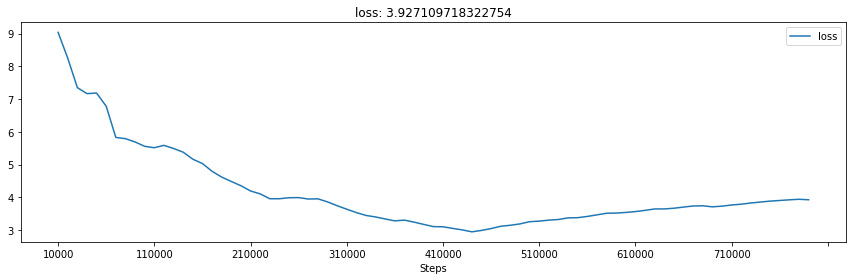

1/2 loss 0.00


In [47]:
hin_embeddings = make_embedding(hin_corpus)

In [48]:
save_embedding(hin_embeddings, "hin_emb.pkl")

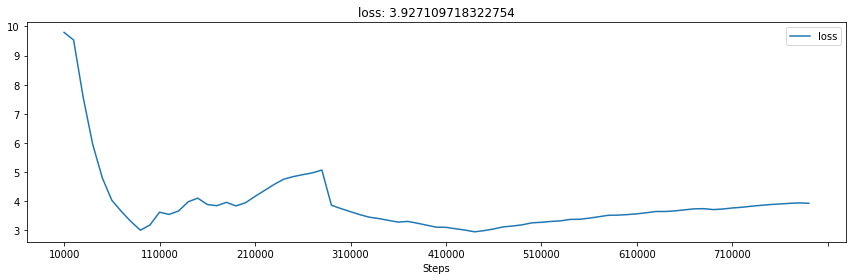

1/2 loss 0.00


In [49]:
tel_embeddings = make_embedding(tel_corpus)

In [50]:
save_embedding(tel_embeddings, "tel_emb.pkl")

# Fetch Embeddings

In [41]:
unique_vocab = list(set(hin_corpus.split(' ')))
print(len(unique_vocab))
word_1 = unique_vocab[2]
word_2 = unique_vocab[3]
word_to_idx = {w: i for i, w in enumerate(unique_vocab)}
    
word_1_vec = hin_embeddings.get_word_vector(word_to_idx[word_1])
word_2_vec = hin_embeddings.get_word_vector(word_to_idx[word_2])

print(word_1_vec.shape)
print(word_2_vec.shape)

44870
torch.Size([1, 300])
torch.Size([1, 300])


In [9]:
tel_embeddings = make_embedding(tel_corpus)